(Click on the below links to navigate to different sections of the notebook)
# **Overview**  
- <a href="#1"> 1. Importing Data</a>
- <a href="#2"> 2. Preprocessing the Dataset</a>
- <a href="#3"> 3. Explanatory Data Analysis </a>
- <a href="#4"> 4. Divide the data into training, cross-validation and testing data </a>
- <a href="#5"> 5. Model</a>

In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.model_selection import train_test_split # for splitting the dataset in train,test and validation
from sklearn.linear_model import LinearRegression # for linear regression
import seaborn as sns

from sklearn.metrics import mean_squared_error # for calcualting mse

import matplotlib.pyplot as plt #for plotting


# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## <a id="1"> 1. Importing Data </a>

In [51]:
df1 = pd.read_csv('OLX_Car_Data_CSV.csv',encoding= 'latin1')
df2 = df1.sample(frac=1).reset_index(drop=True)# shuffle
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 24973 rows and 9 columns


In [52]:
display(df2.head(5))
df2.columns

,Brand,Condition,Fuel,KMs Driven,Model,Price,Registered City,Transaction Type,Year
0,NaN,NaN,NaN,NaN,NaN,560000,NaN,NaN,NaN
1,Toyota,Used,Petrol,77000.0,Passo,900000,Lahore,Cash,2011.0
2,NaN,NaN,NaN,NaN,NaN,440000,NaN,NaN,NaN
3,Suzuki,Used,CNG,194080.0,Bolan,290000,Karachi,Cash,1991.0
4,Suzuki,Used,CNG,120000.0,Alto,480000,NaN,Cash,2006.0


Index(['Brand', 'Condition', 'Fuel', 'KMs Driven', 'Model', 'Price',
       'Registered City', 'Transaction Type', 'Year'],
      dtype='object')

## <a id="2" > 2. Preprocessing the Dataset</a>

### <a id="2-1" > 2.1 Check for NULLS</a>

In [53]:
df2.isnull().sum(axis = 0)

Brand               2137
Condition           2136
Fuel                2445
KMs Driven          2286
Model               2448
Price                  0
Registered City     4636
Transaction Type    2445
Year                2284
dtype: int64

Replacing "NaN" with "unknown" to treat it as a categorical values in their respective columns

In [54]:
df2['Brand'].fillna(value='unknown', inplace=True)
df2['Condition'].fillna(value='unknown', inplace=True)
df2['Fuel'].fillna(value='unknown', inplace=True)
df2['Model'].fillna(value='unknown', inplace=True)
df2['Registered City'].fillna(value='unknown', inplace=True)
df2['Transaction Type'].fillna(value='unknown', inplace=True)

In [55]:
df2=df2.dropna() #drop rows with atleast a column with missing values
df2.isnull().sum(axis = 0)

Brand               0
Condition           0
Fuel                0
KMs Driven          0
Model               0
Price               0
Registered City     0
Transaction Type    0
Year                0
dtype: int64

In [56]:
df2.shape

(22687, 9)

### <a id="2-2" > 2.2 Check the datatype of columns</a>

In [57]:
df2.dtypes

Brand                object
Condition            object
Fuel                 object
KMs Driven          float64
Model                object
Price                 int64
Registered City      object
Transaction Type     object
Year                float64
dtype: object

In [58]:
df2.describe()

,KMs Driven,Price,Year
count,2.268700e+04,2.268700e+04,22687.000000
mean,1.278112e+05,9.212520e+05,2005.901441
std,5.996726e+05,1.594013e+06,9.564187
min,1.000000e+00,5.000000e+04,1915.000000
25%,1.600000e+04,3.800000e+05,2002.000000
50%,6.651000e+04,6.550000e+05,2008.000000
75%,1.000000e+05,1.150000e+06,2013.000000
max,1.000000e+07,8.765432e+07,2020.000000


### <a id="2-3" > 2.3 Remove Outliers</a>

#### Distribution of "Price"

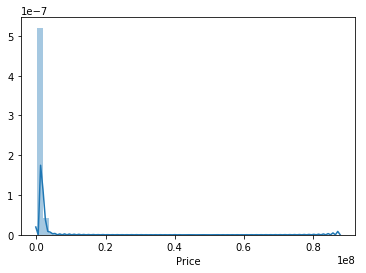

In [59]:
sns.distplot(df2["Price"])

Determine outliers in dataset

In [60]:
cols=['Price']


for i in cols:
    quartile_1,quartile_3 = np.percentile(df2[i],[25,75])
    quartile_f,quartile_l = np.percentile(df2[i],[1,99])
    IQR = quartile_3-quartile_1
    lower_bound = quartile_1 - (1.5*IQR)
    upper_bound = quartile_3 + (1.5*IQR)
    print(i,lower_bound,upper_bound,quartile_f,quartile_l)

    df3[i].loc[df3[i] < lower_bound] = quartile_f
    df3[i].loc[df3[i] > upper_bound] = quartile_l


Price -775000.0 2305000.0 95000.0 4537099.999999992


In [61]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

df2=remove_outlier(df2, 'Price')


#### After removing outlier in 'Price'

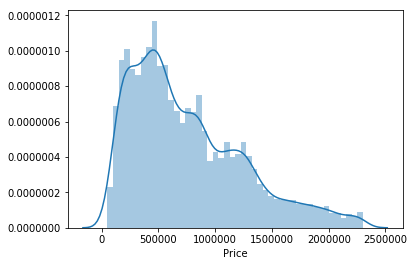

In [62]:
sns.distplot(df2["Price"])

### <a id="2-4" > 2.4 Encoding the categorical data (one hot Encoding)</a>

In [63]:
df3=pd.get_dummies(df2,drop_first=True)
df3.head()

,KMs Driven,Price,Year,Brand_BMW,Brand_Changan,Brand_Chevrolet,Brand_Classic & Antiques,Brand_Daewoo,Brand_Daihatsu,Brand_FAW,...,Registered City_Sialkot,Registered City_Sukkar,Registered City_Sukkur,Registered City_Swabi,Registered City_Tank,Registered City_Vehari,Registered City_Wah,Registered City_unknown,Transaction Type_Installment/Leasing,Transaction Type_unknown
1,77000.0,900000,2011.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,194080.0,290000,1991.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,120000.0,480000,2006.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,67000.0,200000,2015.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,94000.0,876000,2013.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## <a id="3">3. Explanatory Data Analysis </a>

Brand
Suzuki      9675
Toyota      4348
Honda       3058
Daihatsu    2457
Nissan       735
Name: Brand, dtype: int64


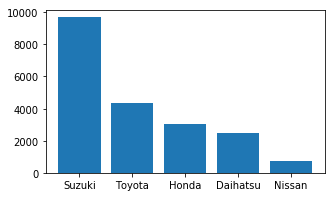

Fuel
Petrol     13666
CNG         6786
Hybrid       754
Diesel       322
unknown      159
Name: Fuel, dtype: int64


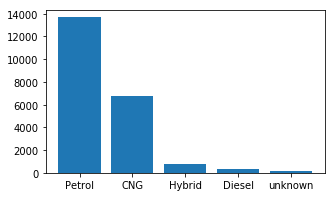

Model
Cultus VXR     1773
Alto           1658
Mehran VX      1024
Corolla GLI     968
Other           879
Name: Model, dtype: int64


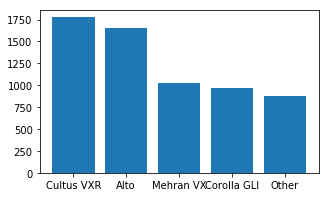

Registered City
Karachi       16045
unknown        2091
Lahore         1931
Islamabad       897
Rawalpindi      159
Name: Registered City, dtype: int64


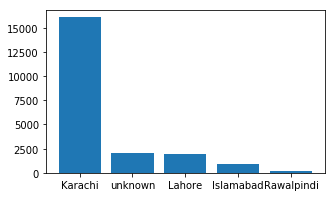

In [64]:
categories = ['Brand','Fuel', 'Model',
       'Registered City']

for i, c in enumerate(categories):
    v = df2[c].unique()
    
    g = df2.groupby(by=c)[c].count().sort_values(ascending=False)
    r = range(min(len(v), 5))

    print( g.head())
    plt.figure(figsize=(5,3))
    plt.bar(r, g.head()) 
    #plt.xticks(r, v)
    plt.xticks(r, g.index)
    plt.show()

## <a id="4"> 4.  Divide the data into training, cross-validation and testing data </a>

In [65]:
df_y = df3['Price'].values
df_X = df3.drop(['Price'], axis=1)


In [66]:
test_size = 0.30

#Split into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(df_X,df_y, test_size=test_size,shuffle=True, random_state = 3)


## <a id="5"> 5. Model</a>

## Random forests

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

param_grid = { "criterion" : ["mse"]
              , "min_samples_leaf" : [3]
              , "min_samples_split" : [3]
              , "max_depth": [10]
              , "n_estimators": [500]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
gs = gs.fit(X_train, Y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   26.4s finished


In [68]:
print(gs.best_score_)
print(gs.best_params_)
 

0.8461166586483374
{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 500}


In [72]:
bp = gs.best_params_
forest = RandomForestRegressor(criterion=bp['criterion'],
                              min_samples_leaf=bp['min_samples_leaf'],
                              min_samples_split=bp['min_samples_split'],
                              max_depth=bp['max_depth'],
                              n_estimators=bp['n_estimators'])
forest.fit(X_train, Y_train)
# Explained variance score: 1 is perfect prediction
print("Test R^2 Score:")
print('Score: %.2f' % forest.score(X_val, Y_val))

Test R^2 Score:
Score: 0.86


In [73]:
print("Train R^2 Score:")
print('Score: %.2f' % forest.score(X_train, Y_train))

Train R^2 Score:
Score: 0.89


In [79]:
# from sklearn.metrics import r2_score
# y_pred=forest.predict(X_val)
# print('Test R^2\nScore: %.2f' % r2_score(Y_val,y_pred))


### R-squared evaluates the scatter of the data points around the fitted regression line.